In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA

from sklearn.manifold import Isomap
from sklearn.manifold import locally_linear_embedding
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import MDS

import tensortools as tt

import matplotlib.pyplot as plt
import pandas as pd
import umap.umap_ as umap
import plotly.express as px
import numpy as np
import os
import plotly.graph_objects as go

In [22]:
d = pd.read_csv(r"doubleExposureData.csv")
data = d.dropna()
startAt = 1
data = data[data["lap"] >= startAt]
data = data.reset_index(drop=True)
allGoodCol = data.columns
allGoodCol = list(allGoodCol)
allGoodCol = allGoodCol[3::]
parsedData = data[allGoodCol].values

meanLength = int(np.mean([len(data[data["lap"] == i]) for i in range(startAt, data["lap"].max() + 1)]))


## Linear PCA

In [23]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X)
    return Xz



In [24]:
pca = PCA(n_components=3, svd_solver='full')
pca_embedding = pca.fit_transform(parsedData)
pca_embedding = pca_embedding[:,0:3]

df = pd.DataFrame(pca_embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='lap', opacity=0.9, title="PCA")
fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [25]:
# For this one, we need to make every trial the same length with interpolation

print("Mean length: ", meanLength)

interpolatedData = np.zeros((meanLength, 3, data["lap"].max() - startAt))
interpolatedPos = np.zeros((meanLength, (data["lap"].max() - startAt)))

for i in range(startAt, data["lap"].max()):

    centredID = i - startAt
    posData = data[data["lap"] == i]

    lapData = pca_embedding[data["lap"] == i, :]

    durationTrial = len(lapData)
    timeVector = [(1/durationTrial) * i for i in range(0, durationTrial)]
    goalVector = [(1/meanLength) * i for i in range(0, meanLength)]
    positionVector = posData["x"]

    if durationTrial != meanLength:
        newDataMat = np.zeros((meanLength, 3))
        interpPos = np.interp(goalVector, timeVector, positionVector)
        for d in range(0, 3):
            neuralData = lapData[:, d]
            interpVector = np.interp(goalVector, timeVector, neuralData)
            newDataMat[:, d] = interpVector
    else:
        newDataMat = lapData

    interpolatedData[:, :, i - startAt] = newDataMat
    interpolatedPos[:, centredID] = interpPos

mean_Trajectory = np.mean(interpolatedData, axis = 2)
mean_Position = np.mean(interpolatedPos, axis = 1)

interpDF = pd.DataFrame(mean_Trajectory, columns=['x1', 'x2', 'x3'])
interpDF["x"] = mean_Position

fig = px.scatter_3d(interpDF, x = "x1", y = "x2", z = "x3", color = "x", opacity=0.9, 
                    title="Mean trajectory PCA")
fig.show()

Mean length:  40


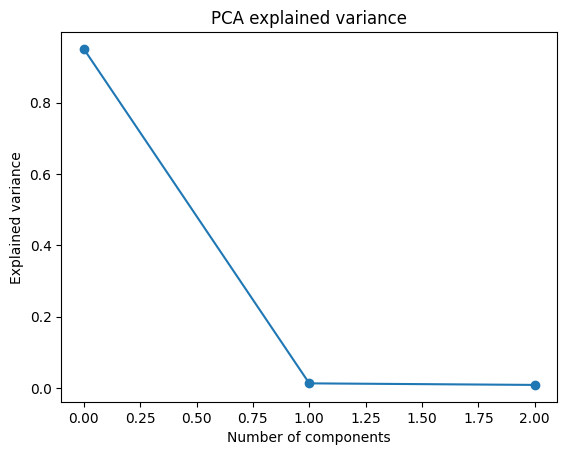

In [26]:
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.title("PCA explained variance")
plt.show()

## ICA

In [27]:
ica = FastICA(n_components=3, random_state=0, whiten='unit-variance')
ica_embedding = ica.fit_transform(parsedData)
ica_embedding = ica_embedding[:,0:3]

df = pd.DataFrame(ica_embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")
fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Kernel PCA

In [28]:
kpca = KernelPCA(n_components=3, kernel="cosine")
kpca_embedding = kpca.fit_transform(parsedData)
kpca_embedding = kpca_embedding[:,0:3]

df = pd.DataFrame(kpca_embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")

fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [29]:
# For this one, we need to make every trial the same length with interpolation

print("Mean length: ", meanLength)

interpolatedData = np.zeros((meanLength, 3, data["lap"].max() - startAt))
interpolatedPos = np.zeros((meanLength, (data["lap"].max() - startAt)))

for i in range(startAt, data["lap"].max()):

    centredID = i - startAt
    posData = data[data["lap"] == i]

    lapData = kpca_embedding[data["lap"] == i, :]

    durationTrial = len(lapData)
    timeVector = [(1/durationTrial) * i for i in range(0, durationTrial)]
    goalVector = [(1/meanLength) * i for i in range(0, meanLength)]
    positionVector = posData["x"]

    if durationTrial != meanLength:
        newDataMat = np.zeros((meanLength, 3))
        interpPos = np.interp(goalVector, timeVector, positionVector)
        for d in range(0, 3):
            neuralData = lapData[:, d]
            interpVector = np.interp(goalVector, timeVector, neuralData)
            newDataMat[:, d] = interpVector
    else:
        newDataMat = lapData

    interpolatedData[:, :, i - startAt] = newDataMat
    interpolatedPos[:, centredID] = interpPos

mean_Trajectory = np.mean(interpolatedData, axis = 2)
mean_Position = np.mean(interpolatedPos, axis = 1)

interpDF = pd.DataFrame(mean_Trajectory, columns=['x1', 'x2', 'x3'])
interpDF["x"] = mean_Position

fig = px.scatter_3d(interpDF, x = "x1", y = "x2", z = "x3", color = "x", opacity=0.9, title="Mean trajectory KPCA - Cosine Kernel")
fig.show()

Mean length:  40


## Tensor component analysis

In [30]:
# For this one, we need to make every trial the same length with interpolation

print("Mean length: ", meanLength)

interpolatedData = np.zeros((meanLength, len(allGoodCol), data["lap"].max() - startAt))
interpolatedPos = np.zeros((meanLength * (data["lap"].max() - startAt)))

for i in range(startAt, data["lap"].max()):

    centredID = i - startAt

    lapData = data[data["lap"] == i]
    lapData.reset_index(drop=True, inplace=True)

    durationTrial = len(lapData)
    timeVector = [(1/durationTrial) * i for i in range(0, durationTrial)]
    goalVector = [(1/meanLength) * i for i in range(0, meanLength)]
    positionVector = lapData["x"]

    lapData = lapData[allGoodCol].values

    if durationTrial != meanLength:
        newDataMat = np.zeros((meanLength, len(allGoodCol)))
        interpPos = np.interp(goalVector, timeVector, positionVector)
        for c in range(0, len(allGoodCol)):
            neuralData = lapData[:, c]
            interpVector = np.interp(goalVector, timeVector, neuralData)
            newDataMat[:, c] = interpVector
    else:
        newDataMat = lapData

    interpolatedData[:, :, i - startAt] = newDataMat
    interpolatedPos[centredID*meanLength:(centredID + 1)*meanLength] = interpPos

Mean length:  40


Rank-1 models:  min obj, 0.22;  max obj, 0.22;  time to fit, 0.0s


Rank-2 models:  min obj, 0.14;  max obj, 0.22;  time to fit, 0.1s


Rank-3 models:  min obj, 0.10;  max obj, 0.14;  time to fit, 0.3s


Rank-4 models:  min obj, 0.10;  max obj, 0.10;  time to fit, 0.2s


Rank-5 models:  min obj, 0.09;  max obj, 0.14;  time to fit, 0.5s


Rank-6 models:  min obj, 0.09;  max obj, 0.10;  time to fit, 0.4s


Rank-7 models:  min obj, 0.08;  max obj, 0.14;  time to fit, 0.6s


Rank-8 models:  min obj, 0.09;  max obj, 0.14;  time to fit, 0.6s


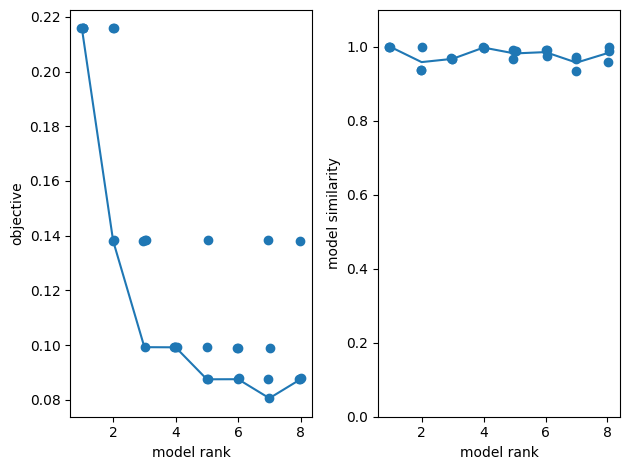

In [31]:
# Fit an ensemble of models, 4 random replicates / optimization runs per model rank
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(interpolatedData, ranks=range(1, 9), replicates=4)

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

## Sammon mapping

In [32]:
def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    import numpy as np 
    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x

    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 

    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).

    An N-dimensional output map is generated by y = sammon(x,n) .

    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):

       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'

    The default options are retrieved by calling sammon(x) with no
    parameters.

    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot

    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].

    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.

    Copyright   : (c) Dr Gavin C. Cawley, November 2007.

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA

    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

In [33]:
# [y, E] = sammon(parsedData, 3)

In [34]:
# df = pd.DataFrame(y, columns=['x1', 'x2', 'x3'])
# df["x"] = data.x
# df["lap"] = data.lap

# fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")

# fig.update_traces(marker_size=2)

# # tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.show()

## Isomap

In [35]:
isomap = Isomap(n_components=3)

isomap_embedding = isomap.fit_transform(parsedData)
isomap_embedding = isomap_embedding[:,0:3]

df = pd.DataFrame(isomap_embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")

fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()



In [36]:
# # dimTested = []
# # error = []

# # for nbDim in range(1, 20):
# #     print(nbDim)
# #     x = Isomap(n_components=nbDim)
# #     y = x.fit(parsedData) 
# #     dimTested.append(nbDim)
# #     error.append(x.reconstruction_error())

# plt.plot(dimTested, error, marker='o')
# plt.xlabel("Number of dimensions")
# plt.ylabel("Reconstruction error")
# plt.show()

## Locally Linear Embedding

### Classical

In [37]:
lle_embedding = locally_linear_embedding(parsedData, n_neighbors = 20, n_components=3)

lle_embedding = lle_embedding[0][:,0:3]

df = pd.DataFrame(lle_embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")

fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

### Modified

In [38]:
lle_embedding = locally_linear_embedding(parsedData, n_neighbors = 20, n_components=3, method = 'modified')

lle_embedding = lle_embedding[0][:,0:3]

df = pd.DataFrame(lle_embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")

fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

KeyboardInterrupt: 

### Hessian Eigenmapping

In [ ]:
lle_embedding = locally_linear_embedding(parsedData, n_neighbors = 20, n_components=3, 
                                         method = 'hessian', eigen_solver='dense')

lle_embedding = lle_embedding[0][:,0:3]

df = pd.DataFrame(lle_embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")

fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Laplacian Eigenmaps

Laplacian eigenmaps uses spectral techniques to perform dimensionality reduction.[14] This technique relies on the basic assumption that the data lies in a low-dimensional manifold in a high-dimensional space.[15] This algorithm cannot embed out-of-sample points, but techniques based on Reproducing kernel Hilbert space regularization exist for adding this capability.[16] Such techniques can be applied to other nonlinear dimensionality reduction algorithms as well.

In [ ]:
le = SpectralEmbedding(n_components=3, affinity='nearest_neighbors')
le_embedding = le.fit_transform(parsedData)
le_embedding = le_embedding[:,0:3]

df = pd.DataFrame(le_embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")

fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


## Multi-dimensional scalling

In [ ]:
# mds = MDS(n_components=3, normalized_stress='auto')
# mds_embedding = mds.fit_transform(parsedData)

# df = pd.DataFrame(mds_embedding, columns=['x1', 'x2', 'x3'])
# df["x"] = data.x
# df["lap"] = data.lap

# fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")

# fig.update_traces(marker_size=2)

# # tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.show()

KeyboardInterrupt: 